In [1]:
# Numerical/Stats pack
import numpy as np
from collections import Counter
import math

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
def get_basis(num_qubits, index):
    """
    Parameters
    ----------
    num_qubits : int
        number of qubits.
    index : int
        Which qubit is 1. Order follows measurement order

    Returns
    -------
    base : int
        the basis string where target position is 1
        e.g., num_qubits=5, index=1, then return '01000'

    """
    origin = list('0'*num_qubits)
    origin[index] = '1'
    return ''.join(origin)
    
def qubit_matrix(p0m0,p1m1):
    """
    Parameters
    ----------
    p0m0 : ndarray(dtype=np.float64, dim=num_qubits)
        Pr(0|0) for all qubits
    p1m1 : ndarray(dtype=np.float64, dim=num_qubits)
        Pr(1|1) for all qubits

    Returns
    -------
    mats: np.array(dim=num_qubits*2*2)
        mats[i] is 2-by-2 measurement error transition matrix for ith qubit
    """
    num_qubits = p0m0.shape[0]
    mats = np.zeros((num_qubits,2,2), dtype=np.float64)
    for i in range(num_qubits):
        mats[i] = np.array([[p0m0[i], 1-p1m1[i]],[1-p0m0[i], p1m1[i]]])
        
    return mats

def dictToVec(nQubits, counts):
    """ Transfer counts to probabilities

    Args:
      nQUbits: int
        number of qubits
      counts: dict
        an dictionary in the form {basis string: frequency}. E.g.
        {"01": 100
         "11": 100}
        dict key follow little-endian convention

    Returns: numpy array
      an probability vector (array). E.g.
      [0, 0.5, 0, 0.5] is the result from example above.
    """
    vec = np.zeros(2**nQubits)
    form = "{0:0" + str(nQubits) + "b}"
    for i in range(2**nQubits):
        key = form.format(i) # consider key = format(i,'0{}b'.format(nQubits))
                             # and delete variable form
        if key in counts.keys():
            vec[i] = int(counts[key])
        else:
            vec[i] = 0
    return vec


def print_info(mat):
    print("Inf norm={:.4g}, Frobenius norm={:.4g}, 2-Norm={:.4g}".format(np.linalg.norm(mat, ord=np.inf), 
                                                                              np.linalg.norm(mat, ord='fro'),
                                                                              np.linalg.norm(mat, ord=2)))
    print("Among {:d} entries, {:d} entries < 1e-3, {:d} entries < 1e-4, {:d} entries < 1e-6".format(mat.shape[0]*mat.shape[1],
                                                                                                      mat[np.abs(mat)<1e-3].shape[0],
                                                                                                      mat[np.abs(mat)<1e-4].shape[0], 
                                                                                                      mat[np.abs(mat)<1e-6].shape[0]))

In [3]:
# Cite https://www.geeksforgeeks.org/check-whether-two-numbers-differ-one-bit-position/
  
# function to check if x is power of 2 
def isPowerOfTwo( x ): 
  
    # First x in the below expression is 
    # for the case when x is 0 
    return x and (not(x & (x - 1))) 
  
# function to check whether the two numbers 
# differ at one bit position only 
def differAtOneBitPos( a , b ): 
    return isPowerOfTwo(a ^ b) 
 
# Function to find the position of 
# rightmost set bit in 'n'
def getRightMostSetBit(n):
    if (n == 0):
        return 0
 
    return math.log2(n & -n)
 
# Cite https://www.geeksforgeeks.org/position-rightmost-different-bit/
# Function to find the position of 
# rightmost different bit in the 
# binary representations of 'm' and 'n'
def posOfRightMostDiffBit(m, n):
 
    # position of rightmost different
    # bit
    return int(getRightMostSetBit(m ^ n))

In [40]:
# Choose machine
# file_address = "./QuitoData/" # Both machine has 5 qubits
# file_address = "./LimaData/" # Both machine has 5 qubits
file_address = './BelemData/'
num_qubits = 5

In [41]:
# Full Matrix
mean_mat = np.zeros((2**num_qubits,2**num_qubits))
for bn in range(2**num_qubits):
    target = format(bn, "0{:d}b".format(num_qubits))
    string_data = np.genfromtxt(file_address + 'Basis'+target+'.csv', delimiter=',',dtype=np.str)
    mean_mat[:,int(target,2)] = dictToVec(num_qubits,dict(Counter(string_data)))/string_data.shape[0]

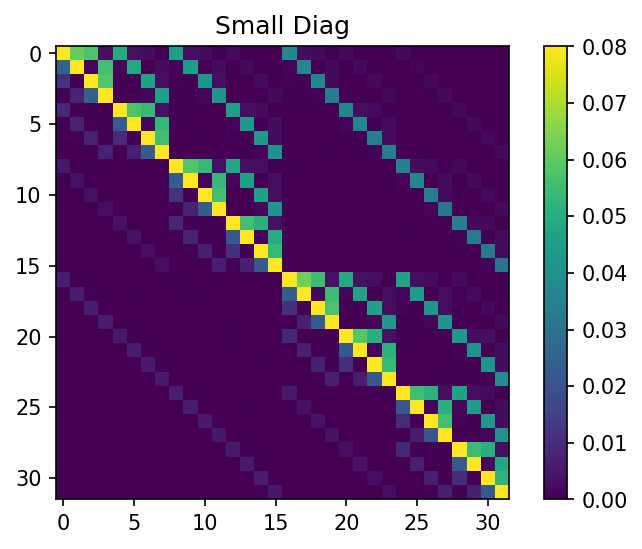

In [42]:
small_diag = np.copy(mean_mat)
for i in range(2**num_qubits):
    small_diag[i,i] = 0.08

plt.imshow(small_diag)
plt.colorbar()
plt.title("Small Diag")
plt.show()

In [43]:
# Check singular values
u, s, vh = np.linalg.svd(small_diag, full_matrices=True)
s

array([0.23697444, 0.19123169, 0.18465557, 0.176103  , 0.16639033,
       0.14838651, 0.14478057, 0.13354174, 0.12946805, 0.12540478,
       0.11803149, 0.11163688, 0.11040136, 0.1017415 , 0.0983371 ,
       0.09427945, 0.08493243, 0.08240303, 0.07738091, 0.07508641,
       0.0738639 , 0.0713727 , 0.05775482, 0.05456908, 0.0512709 ,
       0.04001236, 0.0358662 , 0.02633208, 0.01044276, 0.00632636,
       0.002722  , 0.00048906])

# $$A_{full} = A_{ind} + A_{mask}$$
# $$ A_{mask} = A_{full} - A_{ind}$$

## where each entry in $A_{mask}$ ideally should close to 0.

# Method 1

For example, if we have 5 qubits and we compute Pr(0|0) for Qubit 1, then we go to **data from circuit that constructs 00000** and have $$ Pr(0|0) =1 - \frac{m(01000)}{m(00000) + m(01000)}, $$ where $m()$ is the number of appearences of a given base in some dataset.

Similarly, if we compute Pr(1|1) for Qubit 1, then we go to **data from circuit that constructs 11111** and have $$ Pr(1|1) = 1 - \frac{m(10111)}{m(10111) + m(11111)}. $$

So we need 2 circuits.



## Lima

Difference between full matrix and the matrix from this method:

Inf norm=0.01284, Frobenius norm=0.01941, 2-Norm=0.007467

Among 1024 entries, 949 entries < 1e-3, 757 entries < 1e-4, 209 entries < 1e-6

## Quito

Inf norm=0.01759, Frobenius norm=0.0324, 2-Norm=0.01149

Among 1024 entries, 930 entries < 1e-3, 706 entries < 1e-4, 178 entries < 1e-6


## Belem
Inf norm=0.01627, Frobenius norm=0.02432, 2-Norm=0.01018

Among 1024 entries, 926 entries < 1e-3, 729 entries < 1e-4, 177 entries < 1e-6

In [44]:
p0m1_count = np.zeros(num_qubits, dtype=np.int) # Record number of appearease of prepare 0 measure 1
p0m0_total = np.zeros(num_qubits, dtype=np.int) # Record number of data entries does not have correlated errors

string_data = np.genfromtxt(file_address + 'Basis'+('0'*num_qubits)+'.csv', delimiter=',',dtype=np.str)
for bits in string_data:
    if bits.count("1") == 0: # When all qubits are noise-free
        p0m0_total = p0m0_total + 1 
    if bits.count("1") == 1:
        pos = bits.find('1') # Postion of the bit 1
        p0m1_count[pos] += 1
        p0m0_total[pos] += 1

# Record probability of prepare 0 measure 0
p0m0 = (p0m0_total-p0m1_count)/p0m0_total


p1m0_count = np.zeros(num_qubits, dtype=np.int) # Record number of appearease of prepare 1 measure 0
p1m1_total = np.zeros(num_qubits, dtype=np.int) # Record number of data entries does not have correlated errors

string_data = np.genfromtxt(file_address + 'Basis'+('1'*num_qubits)+'.csv', delimiter=',',dtype=np.str)
for bits in string_data:
    if bits.count("0") == 0: # When all qubits are noise-free
        p1m1_total = p1m1_total + 1 
    if bits.count("0") == 1:
        pos = bits.find('0') # Postion of the bit 1
        p1m0_count[pos] += 1
        p1m1_total[pos] += 1

# Record probability of prepare 1 measure 1
p1m1 = (p1m1_total-p1m0_count)/p1m1_total

# Method 2

For example, if we have 5 qubits and we compute Pr(0|0) for Qubit 1, then we go to **data from circuit that constructs 10111** and have $$ Pr(0|0) = \frac{m(10111)}{m(10111) + m(11111)}, $$ where $m()$ is the number of appearences of a given base in some dataset.

Similarly, if we compute Pr(1|1) for Qubit 1, then we go to **data from circuit that constructs 01000** and have $$ Pr(1|1) = \frac{m(01000)}{m(01000) + m(00000)}. $$

So we need $2n$ number of circuits where $n$ is the number of qubits. (~60000 measurements for 1 probability)


 ## Lima

Difference between full matrix and the matrix from this method:

Inf norm=0.01047, Frobenius norm=0.01927, 2-Norm=0.007424

Among 1024 entries, 956 entries < 1e-3, 762 entries < 1e-4, 227 entries < 1e-6

### use first 25% data

Inf norm=0.01801, Frobenius norm=0.03068, 2-Norm=0.0107

Among 1024 entries, 927 entries < 1e-3, 747 entries < 1e-4, 233 entries < 1e-6


## Quito
Inf norm=0.01774, Frobenius norm=0.0245, 2-Norm=0.01069

Among 1024 entries, 942 entries < 1e-3, 739 entries < 1e-4, 203 entries < 1e-6

### use first 25% data
Inf norm=0.02356, Frobenius norm=0.04237, 2-Norm=0.0156

Among 1024 entries, 913 entries < 1e-3, 708 entries < 1e-4, 201 entries < 1e-6


## Belem
Inf norm=0.01527, Frobenius norm=0.02253, 2-Norm=0.008683

Among 1024 entries, 948 entries < 1e-3, 751 entries < 1e-4, 192 entries < 1e-6

### use first 25% data
Inf norm=0.01898, Frobenius norm=0.03147, 2-Norm=0.0102

Among 1024 entries, 910 entries < 1e-3, 705 entries < 1e-4, 212 entries < 1e-6

In [45]:
# p0m0 = np.zeros(num_qubits) # Record probability of prepare 0 measure 0
# p0m0_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors


# for index in range(num_qubits):
#     # Read data
#     temp_string = get_basis(num_qubits, index)
#     target = ''.join('1' if s == '0' else '0' for s in temp_string) # Corresponding bit string
#     string_data = np.genfromtxt(file_address + 'Basis'+target+'.csv', delimiter=',',dtype=np.str)
# #     string_data = string_data[:int(string_data.shape[0]/4)]
#     # Record number of 1's when other qubits is noise-free
#     num_data = 0
#     num_0 = 0
#     for bits in string_data:
#         others = bits[:index]+bits[index+1:] # The bits that don't include the interested qubits
#         if others == '1'*(num_qubits-1): # Make sure other qubits is noise-free
#             num_data += 1
#             if bits[index] == '0':
#                 num_0 += 1
                
#     # Record data
#     p0m0[index] = num_0/num_data
#     p0m0_total[index] = num_data
    
    
# p1m1 = np.zeros(num_qubits) # Record probability of prepare 1 measure 1
# p1m1_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors


# for index in range(num_qubits):
#     # Read data
#     target = get_basis(num_qubits, index) # Corresponding bit string
#     string_data = np.genfromtxt(file_address + 'Basis'+target+'.csv', delimiter=',',dtype=np.str)
# #     string_data = string_data[:int(string_data.shape[0]/4)]
#     # Record number of 1's when other qubits is noise-free
#     num_data = 0
#     num_1 = 0
#     for bits in string_data:
#         others = bits[:index]+bits[index+1:] # The bits that don't include the interested qubits
#         if others == '0'*(num_qubits-1): # Make sure other qubits is noise-free
#             num_data += 1
#             if bits[index] == '1':
#                 num_1 += 1
                
#     # Record data
#     p1m1[index] = num_1/num_data
#     p1m1_total[index] = num_data

# Method 3

Use all possible basis circuits

So we need $2^n$ number of circuits where $n$ is the number of qubits. (~900,000 measurements for 1 probability)

 
## Lima

Difference between full matrix and the matrix from this method:

Inf norm=0.01053, Frobenius norm=0.01495, 2-Norm=0.005593

Among 1024 entries, 979 entries < 1e-3, 764 entries < 1e-4, 220 entries < 1e-6

### Use 560,000 measurements for 1 Prob

Inf norm=0.01956, Frobenius norm=0.04031, 2-Norm=0.01378

Among 1024 entries, 904 entries < 1e-3, 723 entries < 1e-4, 205 entries < 1e-6


## Quito

Inf norm=0.01569, Frobenius norm=0.01722, 2-Norm=0.008856

Among 1024 entries, 965 entries < 1e-3, 727 entries < 1e-4, 191 entries < 1e-6

### Use 560,000 measurements for 1 Prob

Inf norm=0.02044, Frobenius norm=0.03067, 2-Norm=0.01026

Among 1024 entries, 932 entries < 1e-3, 709 entries < 1e-4, 184 entries < 1e-6




## Belem

Inf norm=0.01126, Frobenius norm=0.01798, 2-Norm=0.006482

Among 1024 entries, 952 entries < 1e-3, 751 entries < 1e-4, 185 entries < 1e-6

### Use 560,000 measurements for 1 Prob

Inf norm=0.0179, Frobenius norm=0.03217, 2-Norm=0.01091

Among 1024 entries, 898 entries < 1e-3, 715 entries < 1e-4, 206 entries < 1e-6

In [46]:
# p0m0_count = np.zeros(num_qubits) # Record counts of prepare 0 measure 0
# p0m0_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors
# p1m1_count = np.zeros(num_qubits) # Record counts of prepare 1 measure 1
# p1m1_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors

# # Go through all possibile basis datasets
# for bn in range(2**num_qubits):
#     target = format(bn, "0{:d}b".format(num_qubits))
#     string_data = np.genfromtxt(file_address + 'Basis'+target+'.csv', delimiter=',',dtype=np.str)
# #     string_data = string_data[:4000]
    
#     # Then for each data (bitstring) in the dataset
#     for meas_res in string_data:
#         meas_int = int(meas_res, 2) # to binary number
#         if meas_res == target: # If there is no error
#             for i in range(num_qubits):
#                 if int(target[i],2): # if bit is 1
#                     p1m1_count[i] += 1
#                     p1m1_total[i] += 1
#                 else:
#                     p0m0_count[i] += 1
#                     p0m0_total[i] += 1
        
#         if differAtOneBitPos(bn, meas_int): # if given basis and measured basis only differ by 1 bit
#             diff_pos = num_qubits - posOfRightMostDiffBit(bn, meas_int) - 1 # position that the bit is different
#             if target[diff_pos] == '0':
#                 p0m0_total[diff_pos] += 1
#             else:
#                 p1m1_total[diff_pos] += 1
            
# # Record probability of prepare 0 measure 0
# p0m0 = p0m0_count/p0m0_total
# # Record probability of prepare 1 measure 1
# p1m1 = p1m1_count/p1m1_total

In [47]:
p0m0, p0m0_total, p1m1, p1m1_total

(array([0.99274977, 0.99443207, 0.99057923, 0.98765769, 0.97378153]),
 array([62067, 61962, 62203, 62387, 63276]),
 array([0.961418  , 0.95145465, 0.94961284, 0.94081038, 0.93567328]),
 array([52045, 52590, 52692, 53185, 53477]))

In [48]:
np.sqrt(1/60000), np.sqrt(1/900000)

(0.004082482904638631, 0.0010540925533894597)

In [49]:
# Construct 5 matrices
single_qubit_mats = qubit_matrix(p0m0,p1m1)

In [50]:
single_qubit_mats

array([[[0.99274977, 0.038582  ],
        [0.00725023, 0.961418  ]],

       [[0.99443207, 0.04854535],
        [0.00556793, 0.95145465]],

       [[0.99057923, 0.05038716],
        [0.00942077, 0.94961284]],

       [[0.98765769, 0.05918962],
        [0.01234231, 0.94081038]],

       [[0.97378153, 0.06432672],
        [0.02621847, 0.93567328]]])

In [51]:
# matrix with independent assumption
ind_mat = single_qubit_mats[0]
for i in range(1,num_qubits):
    ind_mat = np.kron(ind_mat, single_qubit_mats[i])

Inf norm=1.219, Frobenius norm=4.832, 2-Norm=1.033
Among 1024 entries, 728 entries < 1e-3, 521 entries < 1e-4, 329 entries < 1e-6


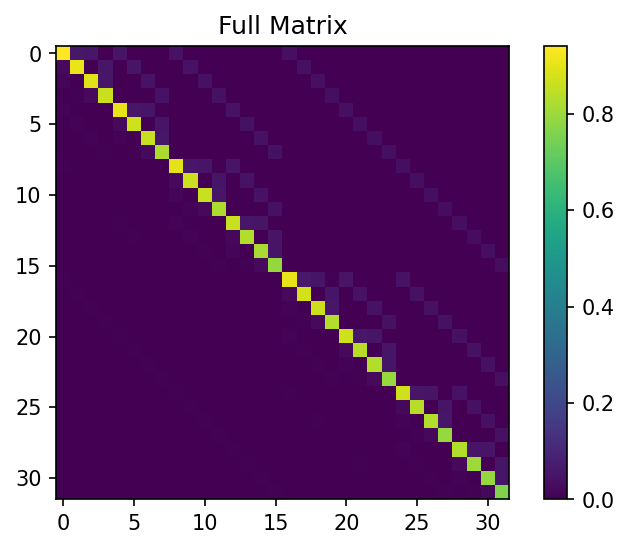

In [52]:
# plt.rcParams["figure.figsize"] = (10, 11)
plt.rcParams["figure.dpi"] = 150

print_info(mean_mat)
plt.imshow(mean_mat)
plt.colorbar()
plt.title("Full Matrix")
plt.show()

Inf norm=1.217, Frobenius norm=4.827, 2-Norm=1.031
Among 1024 entries, 728 entries < 1e-3, 518 entries < 1e-4, 169 entries < 1e-6


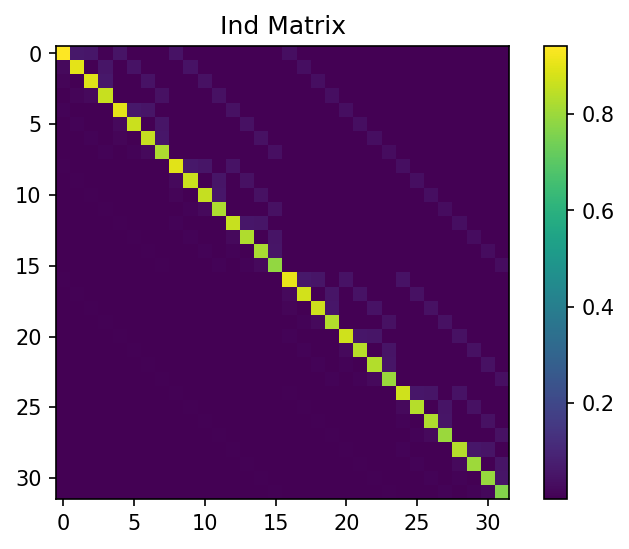

In [53]:
print_info(ind_mat)
plt.imshow(ind_mat)
plt.colorbar()
plt.title("Ind Matrix")
plt.show()

Inf norm=0.01627, Frobenius norm=0.02432, 2-Norm=0.01018
Among 1024 entries, 926 entries < 1e-3, 729 entries < 1e-4, 177 entries < 1e-6


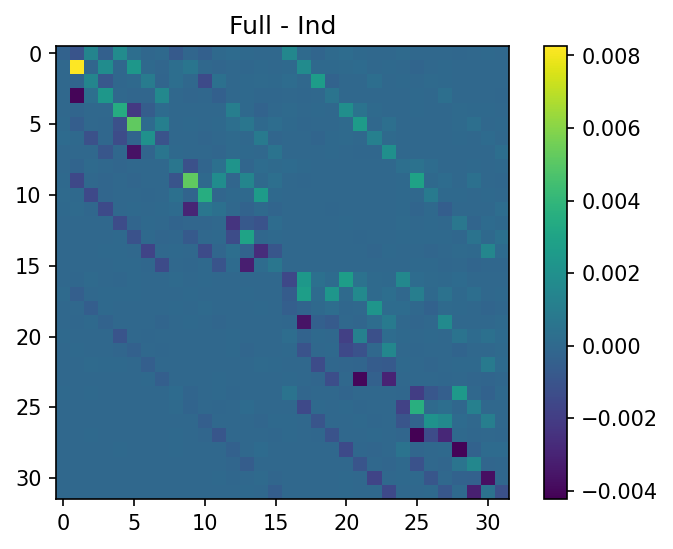

In [54]:
# Differences
diff_mat = mean_mat - ind_mat
print_info(diff_mat)

# for i in range(2**num_qubits):
#     diff_mat[i,i] = 0

plt.imshow(diff_mat)
plt.colorbar()
plt.title("Full - Ind")
plt.show()

In [19]:
# Check singular values
u, s, vh = np.linalg.svd(diff_mat, full_matrices=True)
s

array([7.46745056e-03, 6.41722939e-03, 5.86533144e-03, 5.62415472e-03,
       5.28394029e-03, 4.85409227e-03, 4.54221844e-03, 4.36092178e-03,
       4.27301177e-03, 4.02629607e-03, 3.72381339e-03, 3.63370899e-03,
       3.35730802e-03, 3.06613407e-03, 3.03201664e-03, 2.75363209e-03,
       2.35220983e-03, 2.13779677e-03, 1.90381369e-03, 1.74817021e-03,
       1.37747459e-03, 1.29148669e-03, 1.03049146e-03, 9.53594023e-04,
       7.15089834e-04, 6.43055368e-04, 5.04890290e-04, 3.38093087e-04,
       2.33288554e-04, 1.06039402e-04, 1.84481065e-05, 2.25437686e-18])

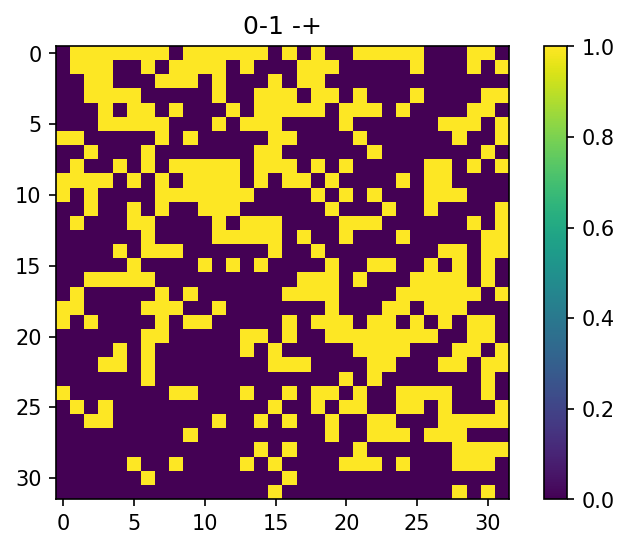

In [20]:
test_mat = np.copy(diff_mat)
test_mat[test_mat >= 0] = 1
test_mat[test_mat < 0] = 0

plt.imshow(test_mat)
plt.colorbar()
plt.title("0-1 -+")
plt.show()

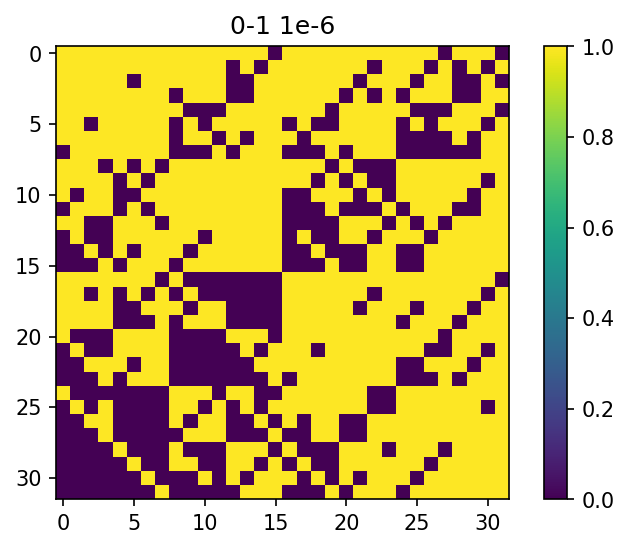

In [21]:
test_mat = np.copy(mean_mat)
test_mat[test_mat < 1e-6] = 0
test_mat[test_mat >= 1e-6] = 1

plt.imshow(test_mat)
plt.colorbar()
plt.title("0-1 1e-6")
plt.show()

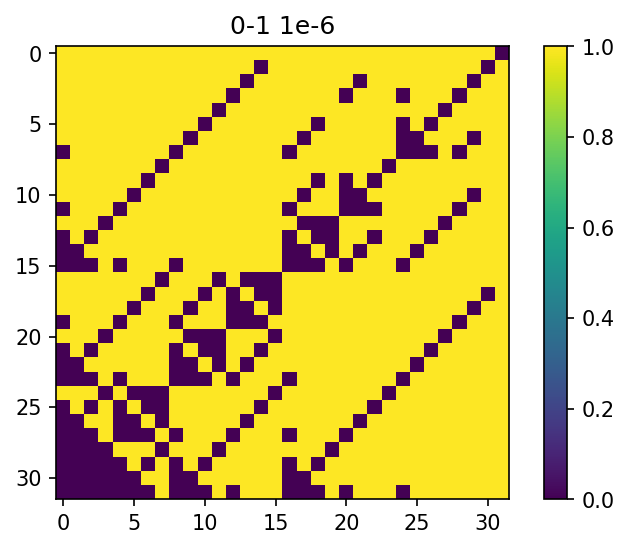

In [22]:
test_mat = np.copy(ind_mat)
test_mat[test_mat < 1e-6] = 0
test_mat[test_mat >= 1e-6] = 1

plt.imshow(test_mat)
plt.colorbar()
plt.title("0-1 1e-6")
plt.show()

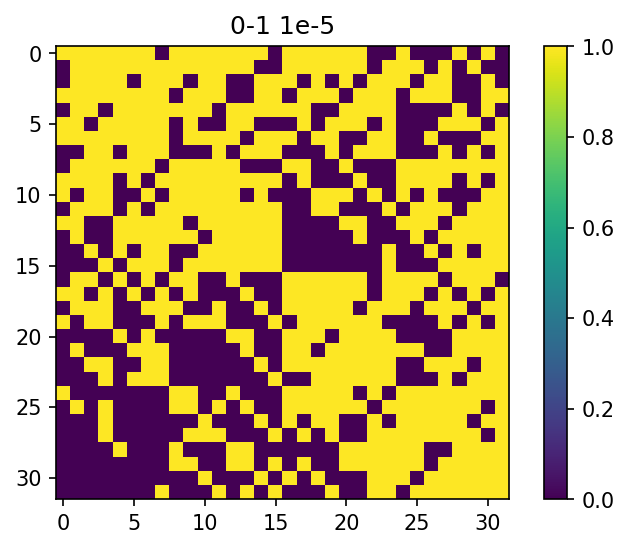

In [23]:
test_mat = np.copy(np.abs(diff_mat))
test_mat[test_mat < 1e-5] = 0
test_mat[test_mat >= 1e-5] = 1

plt.imshow(test_mat)
plt.colorbar()
plt.title("0-1 1e-5")
plt.show()

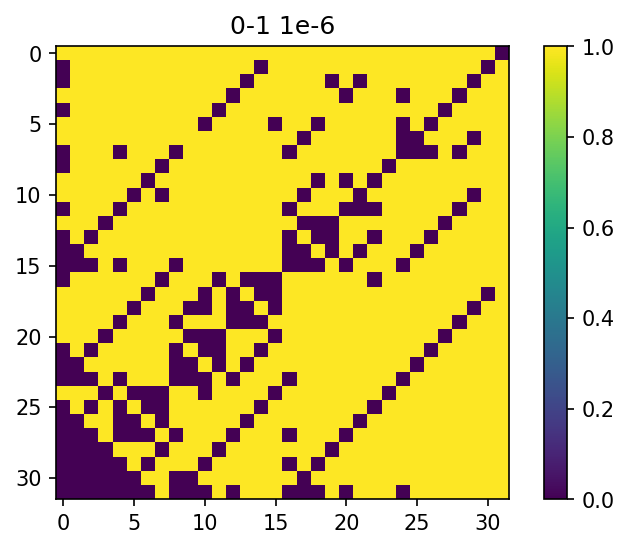

In [24]:
test_mat = np.copy(np.abs(diff_mat))
test_mat[test_mat < 1e-6] = 0
test_mat[test_mat >= 1e-6] = 1

plt.imshow(test_mat)
plt.colorbar()
plt.title("0-1 1e-6")
plt.show()